In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import os
import sys

from sklearn.preprocessing import StandardScaler
from tools import Tools, SimpleMnistTrainer

This section defines hyperparameters. In simple terms, these are the numbers on which the training depends very much, and its hard to predict just how much. Especially: learning rate, which defines how 'far' should gradients be used to shift vectors.

In [2]:
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 2500
DROPOUT = 0.5
BATCH_SIZE = 50
VALIDATION_SIZE = 2000
IMAGE_TO_DISPLAY = 7
LOCAL_PATH = 'data'
TRAIN_DATA = os.path.join(LOCAL_PATH, "train.csv")
TEST_DATA = os.path.join(LOCAL_PATH, "test.csv")

In [3]:
data = pd.read_csv(TRAIN_DATA)
print('data({0[0]},{0[1]})'.format(data.shape))
print(data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [4]:
images = data.iloc[:, 1:].values
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0)
image_size = images.shape[1]
Tools.display(images[33], 28, 28)
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

In [5]:
labels_flat = data[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
labels = Tools.dense_to_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [6]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]
train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

Begin defining all variables involved in computational graph. The SimpleMnistTrainer is a small class in tools.py file.

In [7]:
x = tf.placeholder('float', shape=[None, image_size])
y_labels = tf.placeholder('float', shape=[None, labels_count])
trainer = SimpleMnistTrainer()
trainer.train_images = train_images
trainer.train_labels = train_labels

Define weights and biases in first layer. Define RELU (rectifined linear) 2D convolution.

In [8]:
W_conv1 = Tools.weight_variable(shape=[5, 5, 1, 32], name="Layer1_weights")
b_conv1 = Tools.bias_variable([32], name="Layer1_biases")
image = tf.reshape(x, [-1, image_width, image_height, 1])
h_conv1 = tf.nn.relu(Tools.convolution2d(image, W_conv1) + b_conv1)
h_pool1 = Tools.max_pool_2x2(h_conv1)

Reshape to make a layer.

In [9]:
# show 32 features in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4, 8))

# reorder: channels, x, y
layer1 = tf.transpose(layer1, (0, 3, 1, 4, 2))
layer1 = tf.reshape(tensor=layer1, shape=(int(image_height) * 4, int(image_width * 8)), name="Layer1Reshape")

Define weights and biases in second layer. Define RELU (rectifined linear) 2D convolution.

In [10]:
W_conv2 = Tools.weight_variable([5, 5, 32, 64], name="Layer2_weights")
b_conv2 = Tools.bias_variable([64], name="Layer2_biases")
h_conv2 = tf.nn.relu(Tools.convolution2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = Tools.max_pool_2x2(h_conv2)

In [11]:
# display 64 features in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4, 16))

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4, 2))
layer2 = tf.reshape(layer2, (-1, 14 * 4, 14 * 16))

Define third layer - densely connected layer.

In [12]:
W_fc1 = Tools.weight_variable([7 * 7 * 64, 1024], name="Layer3_fc_weights")
b_fc1 = Tools.bias_variable([1024], name="Layer3_fc_biases")
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Additional algorithms. To prevent overfitting, use drop-out.

In [13]:
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Final layer is the output layer, a 'softmax', to convert output to one of 10 classes, for 10 digits.

In [14]:
W_fc2 = Tools.weight_variable([1024, labels_count], name="Layer4_softmax_weights")
b_fc2 = Tools.bias_variable([labels_count], name="Layer4_softmax_biases")

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Having all the layers defined, now we specify how we are going to train the network. Define cost function, optimisation for gradient descent, and how to evaluate accuracy of predictions.

In [15]:
# cost function
cross_entropy = -tf.reduce_sum(y_labels * tf.log(y))
# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
# evaluate
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
predict = tf.argmax(y, 1)

Initialize variables for training.

In [16]:
train_accuracies = []
validation_accuracies = []
x_range = []
display_step = 10
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]
trainer.number_of_examples = num_examples
print("Number of examples: " + str(num_examples))

Number of examples: 40000


To save our model periodically, use Tensorflow checkpoints.

In [17]:
saver = tf.train.Saver(tf.global_variables())
MODEL_PATH = os.path.join(LOCAL_PATH, "model.ckpt")
with tf.name_scope("summaries"):
    tf.summary.scalar("cost", cross_entropy)
    tf.summary.scalar("accuracy", accuracy)
summary_operations = tf.summary.merge_all()

train_logs = os.path.join(LOCAL_PATH, "train")

Now, we start a Tensorflow session. During this session, all variables are initiated and computational graph is created. To be abble to start training from a previously saved checkpoint, implement a simple check if a checkpoint already exists.

In [18]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    log_writer = tf.summary.FileWriter(train_logs, graph=session.graph)
    
    # This part handles resuming from a checkpoint.
    if os.path.isfile(MODEL_PATH + ".meta"):
        ckpt = tf.train.get_checkpoint_state(LOCAL_PATH)
        
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
    
    # Do if no checkpoints are found.
    else:
        for i in range(TRAINING_ITERATIONS):
            
            batch_xs, batch_ys = trainer.next_batch(BATCH_SIZE)
            
            if i % display_step == 0 or (i + 1) == TRAINING_ITERATIONS:
                train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y_labels: batch_ys, keep_prob: 1.0})

                validation_accuracy = accuracy.eval(feed_dict={x: validation_images[0:BATCH_SIZE],
                                                               y_labels: validation_labels[0:BATCH_SIZE],
                                                               keep_prob: 1.0})
                
                #print('training_accuracy: {0} | validation_accuracy : {1} |  for step {2}'
                #      .format(train_accuracy, validation_accuracy, i))
                
                validation_accuracies.append(validation_accuracy)
                train_accuracies.append(train_accuracy)
                x_range.append(i)
                
                # Increase display_step.
                if i % (display_step * 10) == 0 and i:
                    display_step *= 10

            summary, _ = session.run([summary_operations, train_step], 
                                     feed_dict={x: batch_xs, y_labels: batch_ys, keep_prob: DROPOUT})
            
            log_writer.add_summary(summary, global_step=i)
            
            if i % 100 == 0:
                saver.save(session, MODEL_PATH, global_step=i)

        # Train loop finished. Check final accuracy on validation set
        validation_accuracy = accuracy.eval(feed_dict={x: validation_images,
                                                       y_labels: validation_labels,
                                                       keep_prob: 1.0})
        print('validation_accuracy => %.4f' % validation_accuracy)
        saver.save(session, MODEL_PATH, global_step=TRAINING_ITERATIONS)

validation_accuracy => 0.9795


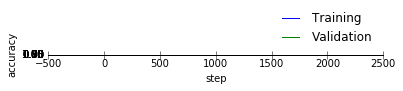

In [19]:
plt.plot(x_range, train_accuracies, '-b', label='Training')
plt.plot(x_range, validation_accuracies, '-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax=1.1, ymin=0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.show()

Test model. Load test data.

In [ ]:
test_images = pd.read_csv(TEST_DATA).values
test_images = test_images.astype(np.float)
test_images = np.multiply(test_images, 1.0 / 255.0)

predicted_labels = np.zeros(test_images.shape[0])

In [19]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # This part handles resuming from a checkpoint.
    ckpt = tf.train.get_checkpoint_state(LOCAL_PATH)
    saver.restore(session, ckpt.model_checkpoint_path)

    for i in range(0, test_images.shape[0] // BATCH_SIZE):
        if i % 10 == 0:
            sys.stdout.write(".")
        predicted_labels[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = \
            predict.eval(feed_dict={x: test_images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE], keep_prob: 1.0})

    print('predicted_labels({0})'.format(len(predicted_labels)))
    
    # Show test image and prediction
    Tools.display(test_images[IMAGE_TO_DISPLAY], image_width, image_height)
    print('predicted_labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY, predicted_labels[IMAGE_TO_DISPLAY]))
    
    test_images = StandardScaler().fit_transform(np.float32(test_images.values))
    test_images = test_images.reshape(-1, 28, 28, 1)
    layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY + 1], keep_prob: 1.0})
    plt.imshow(test_images[IMAGE_TO_DISPLAY, :, :, 0])
    plt.show()
    print(predicted_labels[IMAGE_TO_DISPLAY])
    
    layer2_grid = layer2.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY + 1], keep_prob: 1.0})
    plt.imshow(layer2_grid[0])

.

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`